<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/circle_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [318]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [319]:
x1 = np.random.uniform(low = -1, high = 1, size = (500,1))
x2 = np.random.uniform(low = -1, high = 1, size = (500,1))

In [320]:
X = np.concatenate((x1, x2), axis = 1)
X = X/np.sqrt(x1**2 + x2**2)

In [321]:
Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
Y = np.array(Y)

In [322]:
n_data = len(Y)

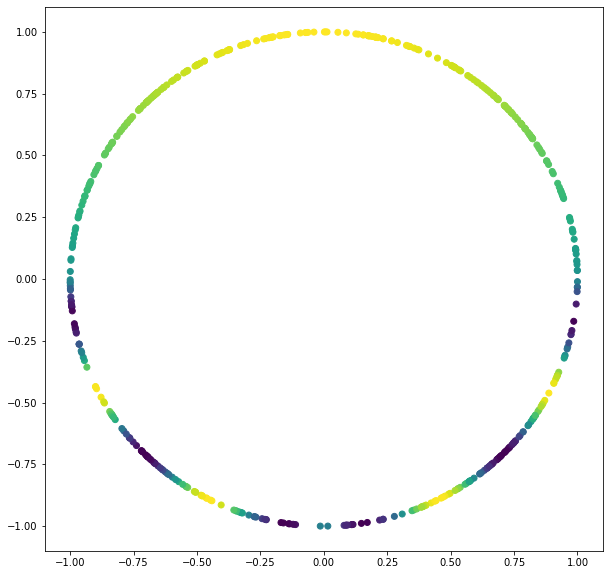

In [346]:
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c = Y)
plt.savefig("Input Data")

In [324]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [325]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.size = len(Y)
        self.x = torch.tensor(X)
        self.y = torch.tensor(Y)

    def __len__(self):
        return (self.size)

    def __getitem__(self, idx):
        #print(self.x[idx].shape,self.y[idx].shape )
        return self.x[idx].float(), self.y[idx].float()


In [326]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (x,y) in enumerate(dataloader):
        X, y = x.to(device), y.to(device)
        pred, _ = model(X.float())
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%16 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred, out

In [327]:
class NeuralNet(nn.Module):
  def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

  def forward(self, x, batch = None):
        x = self.fc1(x)
        o1 = torch.relu(x)
        x = self.fc2(o1)
        o2 = torch.relu(x)
        x = self.fc3(o2)
        o3 = torch.relu(x)
        x = self.fc4(o3)
        return x , [o1, o2, o3]

In [328]:
batch_size = 16
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)

In [329]:
#sorted_arg = np.argsort(X[:, 0])
sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
X_sorted = X[sorted_arg]
Y_sorted = Y[sorted_arg]

batch_size = len(Y)
dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)


In [347]:
model = NeuralNet().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3) 

In [ ]:
epochs = 400
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    pred = train(train_dataloader,model, loss_fn, optimizer)
    test(test_dataloader,model, loss_fn)
print("Done!")


In [332]:
#np.sort(np.arctan2(X[:,1],X[:,0])*180/np.pi)

In [349]:
  prediction, out = test(dataloader,model, loss_fn)

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.003108 



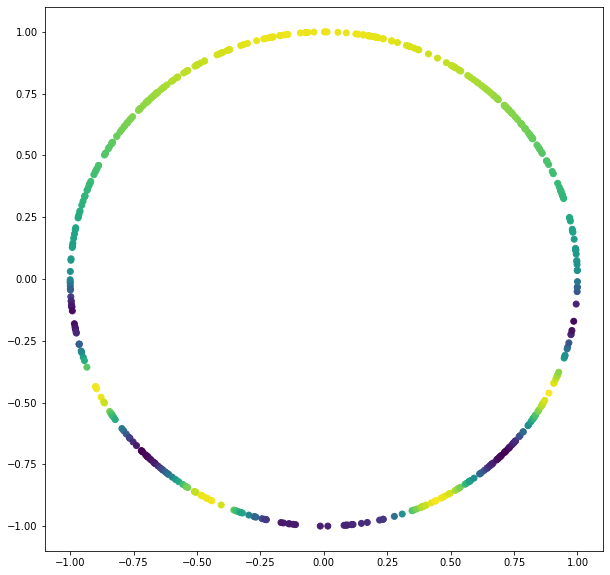

In [351]:
plt.figure(figsize=(10,10))
plt.scatter(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
plt.savefig("regenerated")

In [341]:
temp = np.zeros((3, n_data, 32))
temp[0] = out[0].to("cpu")
temp[1] = out[1].to("cpu")
temp[2] = out[2].to("cpu")

out = temp
out = np.sign(out)

lambda_matrix = np.zeros(shape = (n_data, n_data))

for i in range(n_data):
  for j in range(n_data):
    lambda_matrix[i][j] = np.prod(np.sum(np.multiply(out[:,i,:], out[:,j,:]), axis = 1))
    

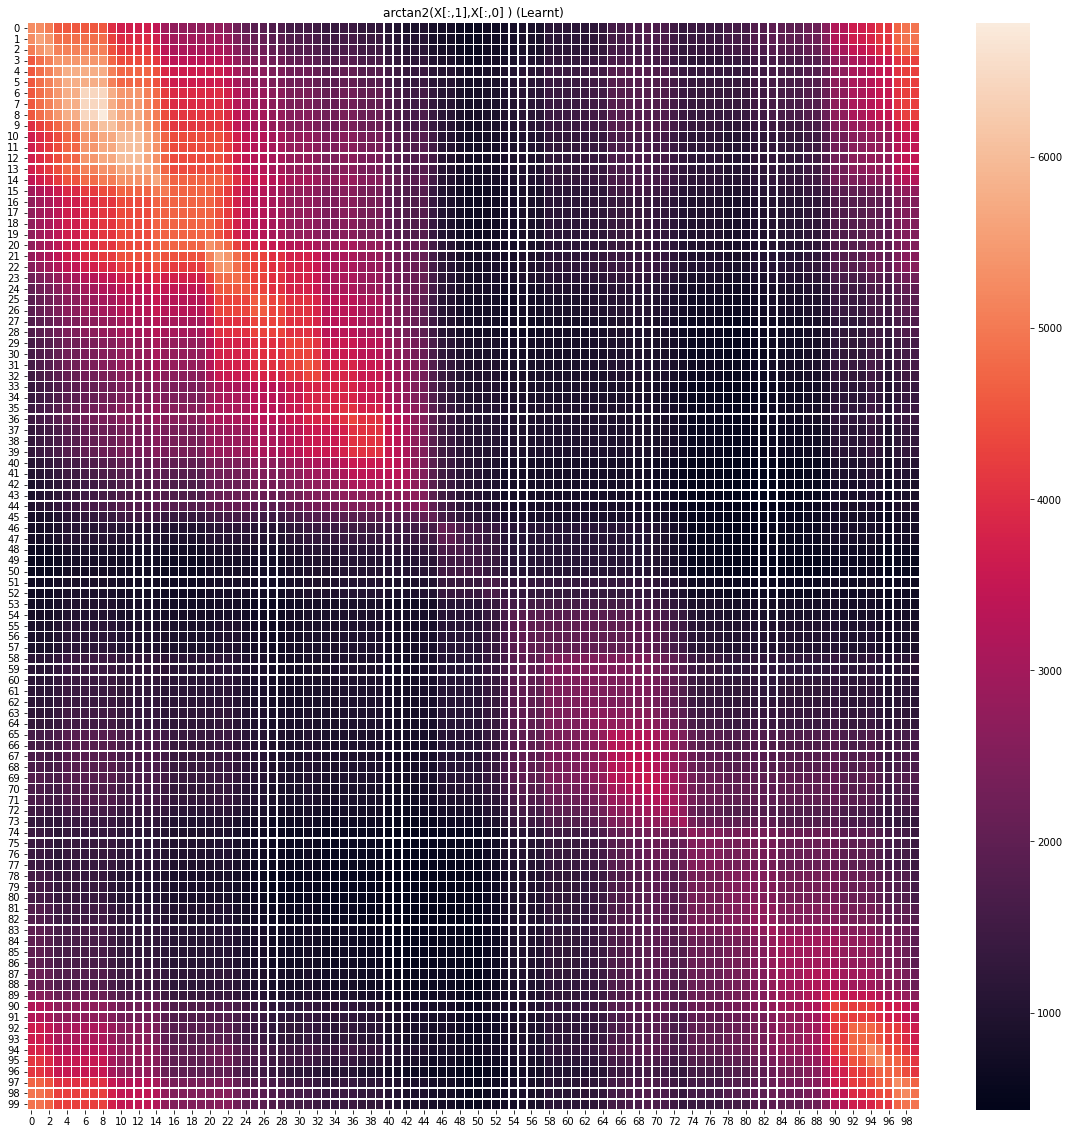

In [342]:
plt.figure(figsize = (20,20))
ax = sns.heatmap(lambda_matrix[0:500:5,0:500:5], linewidth=.2)
plt.title('arctan2(X[:,1],X[:,0] ) (Learnt)')
plt.savefig("arctan2(X[:,1],X[:,0] )(Learnt)")
plt.show()

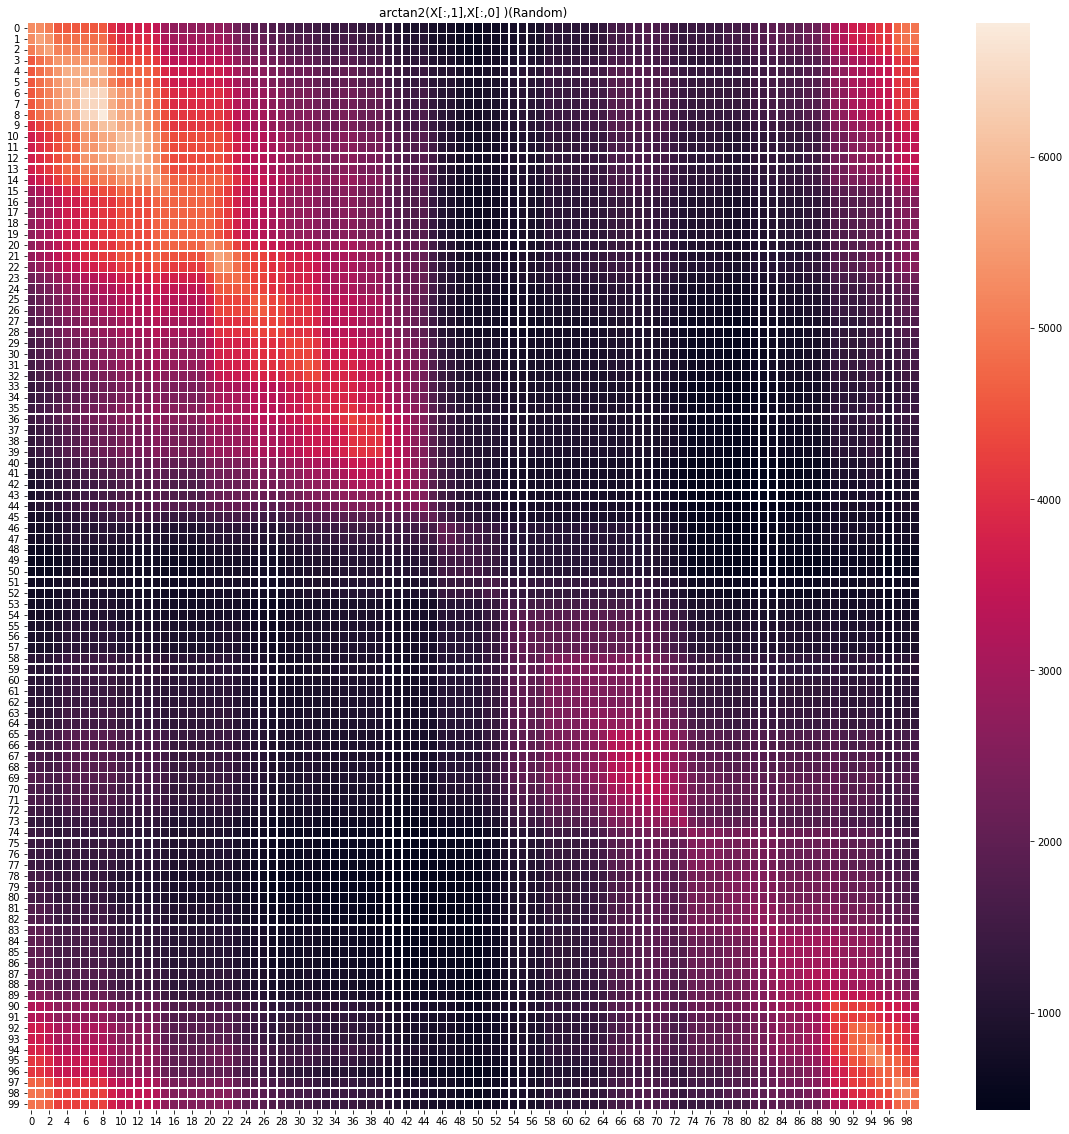

In [343]:
plt.figure(figsize = (20,20))
ax = sns.heatmap(lambda_matrix[0:500:5,0:500:5], linewidth=.2)
plt.title("arctan2(X[:,1],X[:,0] )(Random)")
plt.savefig("arctan2(X[:,1],X[:,0] )(Random)")
plt.show()